In [122]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
from scipy.io import savemat
from tenpy.tools.params import get_parameter
from matplotlib import colors

In [123]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
tenpy.tools.misc.setup_logging(to_stdout="INFO")
import pickle

In [124]:
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg

from tenpy.networks.site import SpinSite, SpinHalfSite, SpinHalfFermionSite
from tenpy.models.lattice import Triangular, Square
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel

In [125]:
''' Fermi-Hubbard model '''

class Hubbard_chiral(CouplingModel, MPOModel):
    def __init__(self, model_param):
        
        ''' system size '''
        Lx = model_param["Lx"]
        Ly = model_param["Ly"]
#         q = model_param["fraction"]
#         Lx = q 
        
        ''' coupling constants'''
        t = model_param["t"]
        U = model_param["U"]
#         phi = model_param["phase"]
        
        
        ''' boundary conditions'''
        bc_MPS = model_param["bc_MPS"]
        bc_y = model_param["bc_y"]
        bc_x = model_param["bc_x"]
        
        
        ''' site with particle + U(1) symmetry conservation'''
        site = SpinHalfFermionSite(cons_N = 'N', cons_Sz = 'Sz')
        
        ''' define triangular lattice'''
        lat = Triangular(Lx, Ly, site, bc=[bc_x, bc_y], bc_MPS=bc_MPS)   
        

        CouplingModel.__init__(self, lat)
        
        
        for i in range(Lx):
            for j in range(Ly):
                
                """ on-site interaction"""
                self.add_onsite_term(U, i * Ly + j, 'NuNd')
                
                ''' hopping along x-direction from (i+1,j) to (i,j)'''
                self.add_coupling_term( -t * 1j, i * Ly + j, (i+1) * Ly + j, 'Cdu', 'Cu', plus_hc=True)
                self.add_coupling_term( -t * 1j, i * Ly + j, (i+1) * Ly + j, 'Cdd', 'Cd', plus_hc=True)
                
                
        for i in range(Lx):
            for j in range(Ly-1):
                
                ''' hopping along y-direction from (i,j) to (i,j+1)'''
                self.add_coupling_term( -t * (-1)**i, i * Ly + j, i * Ly + j + 1, 'Cdu', 'Cu', plus_hc=True)
                self.add_coupling_term( -t * (-1)**i, i * Ly + j, i * Ly + j + 1, 'Cdd', 'Cd', plus_hc=True)
            
        for i in range(Lx):
            for j in range(1,Ly):
                
                '''hopping along diagonal from (i+1,j-1) to (i,j)'''
                self.add_coupling_term( -t * (-1)**(i+1), i * Ly + j, (i+1) * Ly + j - 1, 'Cdu', 'Cu', plus_hc=True)
                self.add_coupling_term( -t * (-1)**(i+1), i * Ly + j, (i+1) * Ly + j - 1, 'Cdd', 'Cd', plus_hc=True)
        
        #provide periodic boundary conditions 
        '''(0,0) -- (0, Ly-1)'''
        self.add_coupling_term( (-t) * (+1), 0, Ly - 1, 'Cdu', 'Cu', plus_hc=True)
        self.add_coupling_term( (-t) * (+1), 0, Ly - 1, 'Cdd', 'Cd', plus_hc=True)
        
        '''(1,0) -- (1, Ly-1)'''
        self.add_coupling_term( (-t) * (-1), Ly, 2*Ly - 1, 'Cdu', 'Cu', plus_hc=True)
        self.add_coupling_term( (-t) * (-1), Ly, 2*Ly - 1, 'Cdd', 'Cd', plus_hc=True)
        
        '''(0,0) -- (1, Ly-1)'''
        self.add_coupling_term( (-t) * (-1), 0, 2*Ly - 1, 'Cdu', 'Cu', plus_hc=True)
        self.add_coupling_term( (-t) * (-1), 0, 2*Ly - 1, 'Cdd', 'Cd', plus_hc=True)
        
        '''(1,0) -- (2, Ly-1)'''
        self.add_coupling_term( (-t) * (+1), Ly, 3*Ly - 1, 'Cdu', 'Cu', plus_hc=True)
        self.add_coupling_term( (-t) * (+1), Ly, 3*Ly - 1, 'Cdd', 'Cd', plus_hc=True)
        
        MPOModel.__init__(self, lat, self.calc_H_MPO())
        
        ax = plt.gca()
        lat.plot_basis(ax)

In [126]:
dmrg_params = {"trunc_params": {"chi_max": 300, "svd_min": 1.e-10}, "mixer": True, "max_sweeps": 500}

In [127]:
model_param = {"Lattice" : Triangular,
              "Ly" : 3,
              "Lx" : 2,
              "t" : 1.0,
              "U" : 0.0,
              "fraction" : 2,
              "bc_MPS" : "infinite",
              "bc_y" : 'periodic',
              "bc_x" : 'periodic'}

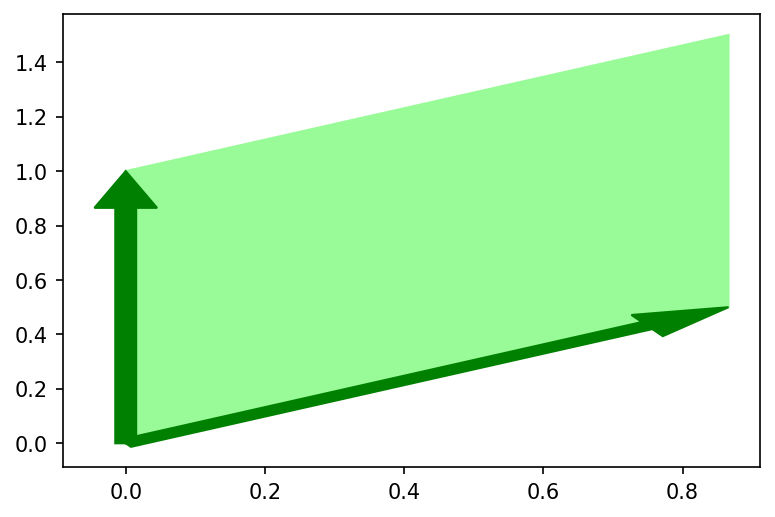

In [128]:
M = Hubbard_chiral(model_param)
sites = M.lat.mps_sites()
psi = MPS.from_product_state(sites,["up","down","down","up","up","down"],"infinite")

In [129]:
# print(M.all_coupling_terms().to_TermList())
# print(M.all_onsite_terms().to_TermList())

In [130]:
info = dmrg.run(psi, M, dmrg_params)
energy = info['E']
delta_energy = abs(info["sweep_statistics"]['E'][-1] - info["sweep_statistics"]['E'][-2])

INFO    : DMRG: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=300
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : DMRG: reading 'max_sweeps'=500
INFO    : DMRG: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Running sweep with optimization
INFO    : start environment_sweep
INFO    : checkpoint after sweep 10
energy=-1.3587771532421584, max S=2.6141627946146504, age=198, norm_err=5.1e-08
Current memory usage 677476.0MB, wall time: 1428.5s
Delta E = nan, Delta S = 2.4068e-01 (per sweep)
max trunc_err = 5.2248e-04, max E_trunc = 2.5592e-03
chi: [300, 300, 300, 300, 300, 300]
INFO    : Running sweep with optimization
INFO    : disable mixer after 15 sweeps, final amplitude 3.05e-10
INFO    : start environment_sweep
INFO    : checkpoint after sweep 20
energy=-1.3588981125621302, max S=2.6062912305904447, age=378, norm_err=4.2e-09
Current m

KeyboardInterrupt: 

In [ ]:
# data = {'psi': psi, 'dmrg_params': dmrg_params, 'Energy': energy, 'Delta Energy': delta_energy, 'model_params': model_param}

In [ ]:
# with open('results_hubbard.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [ ]:
# with open('results_mixed_server.pkl', 'rb') as f:
#     data_load = pickle.load(f)

In [ ]:
# data_load["Energy"]

In [ ]:
# data_load['Delta Energy']